In [ ]:
# bilibili

In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer
from tqdm import tqdm
import torch

# 1. Load cleaned dataset
df = pd.read_csv("bili_cleaned.csv")

# 2. Load tokenizer (ensure max_length=512 and automatic truncation)
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")

# 3. Load sentiment-analysis pipeline, explicitly passing tokenizer and model
classifier = pipeline(
    "sentiment-analysis",
    model="./bili-bert-model/checkpoint-115",
    tokenizer=tokenizer,           # Directly passing the tokenizer object is recommended
    truncation=True,               # Enable truncation of long texts
    # Note: For different pipeline versions, truncation/max_length may need to be handled during tokenization step
)

# 4. Define a robust prediction function with safe tokenization and truncation
def predict_sentiment(text):
    # Tokenize and truncate the input text before inference
    encoded = tokenizer(
        text,
        truncation=True,
        max_length=512,
        padding="max_length",
        return_tensors="pt"
    )
    # Perform inference without gradient computation
    with torch.no_grad():
        output = classifier.model(**encoded)
        scores = output.logits.softmax(dim=1).cpu().numpy()[0]
        label_id = scores.argmax()
        label = classifier.model.config.id2label.get(label_id, f"LABEL_{label_id}")
        score = float(scores[label_id])
        return pd.Series([label, score])

# 5. Apply sentiment prediction to all comments with a progress bar
tqdm.pandas()
df[['pred_label', 'pred_score']] = df['text'].progress_apply(predict_sentiment)

# 6. Save prediction results for downstream analysis
df.to_csv("bili_labeled_with_pred.csv", index=False, encoding="utf-8-sig")

In [62]:
import pandas as pd

df = pd.read_csv("bili_labeled_with_pred.csv")

# Step 1: Convert string sentiment labels to numerical values
df['pred_label_num'] = df['pred_label'].map({'LABEL_1': 1, 'LABEL_0': -1})

# Step 2: Compute weighted sentiment score for each comment
df['result'] = df['pred_label_num'] * df['pred_score'] * df['weight']

In [63]:
monthly_trend = df.groupby('year_month')['result'].mean().reset_index()
target_months = ['2023-03', '2023-04', '2023-11', '2023-12', '2025-10', '2025-11']
monthly_trend = monthly_trend.set_index('year_month').reindex(target_months).fillna(0).reset_index()

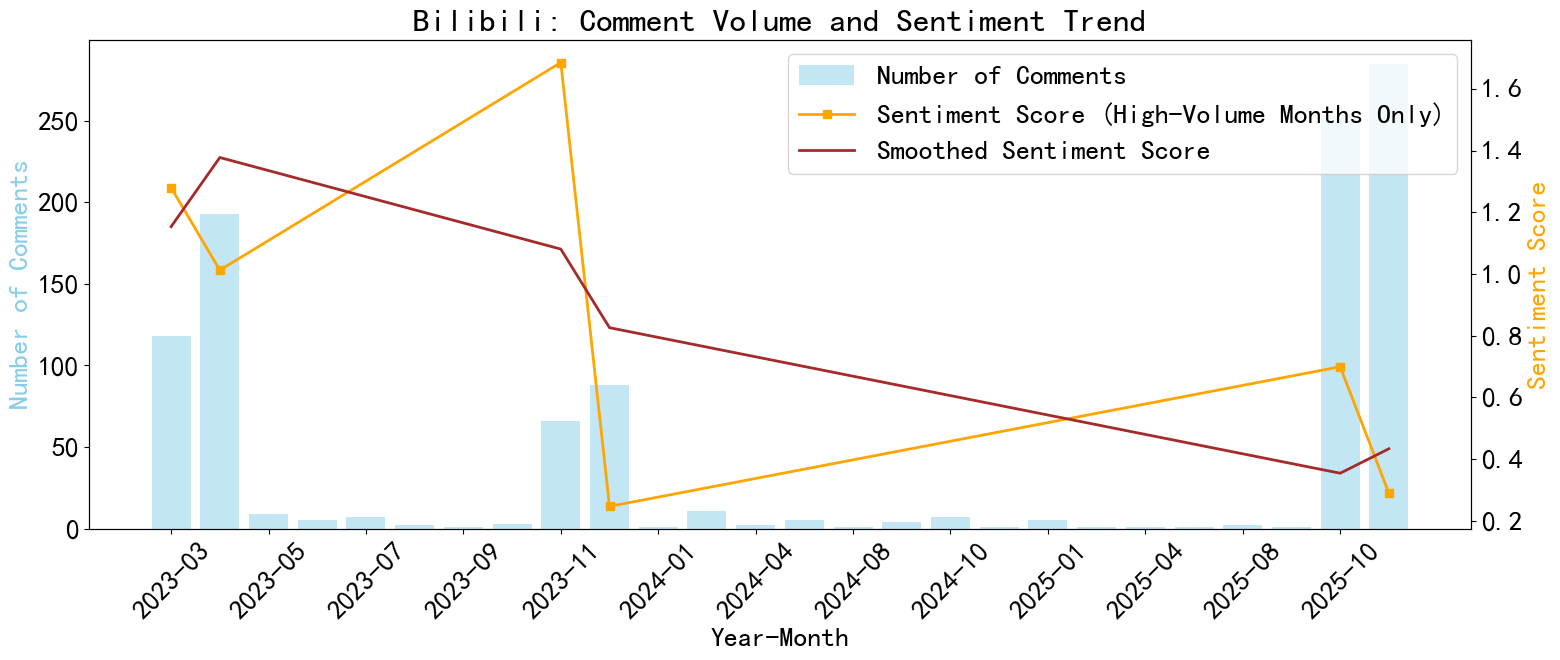

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

comment_counts = df.groupby('year_month').size().reset_index(name='count')
monthly_sentiment = df.groupby('year_month')['result'].mean().reset_index(name='result')
merged_filtered = pd.merge(comment_counts, monthly_sentiment, on='year_month', how='outer').sort_values('year_month')
plt.rcParams.update({'font.size': 20})
# Data Preparation
min_count = 30
points = merged_filtered[merged_filtered['count'] >= min_count].copy()

x_full = merged_filtered['year_month']
y_bar = merged_filtered['count']

x_line = points['year_month'].tolist()
y_line = pd.to_numeric(points['result'], errors='coerce').fillna(np.nan).values

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig, ax1 = plt.subplots(figsize=(16,7))

# Bar chart: comment volume across all months
ax1.bar(x_full, y_bar, color='skyblue', alpha=0.5, label='Number of Comments')
ax1.set_ylabel('Number of Comments', color='skyblue')
ax1.set_xlabel('Year-Month')

# Line chart: weighted sentiment score for high-volume months only
ax2 = ax1.twinx()
ax2.plot(x_line, y_line, 's-', color='orange', linewidth=2, label='Sentiment Score (High-Volume Months Only)')

# Plot smoothed sentiment curve using Savitzky-Golay filter
if len(y_line) >= 5:
    # Ensure window_length is odd and not greater than the number of data points
    win_len = min(7, len(y_line)) if len(y_line) % 2 == 1 else min(7, len(y_line)-1)
    win_len = max(3, win_len)
    y_smooth = savgol_filter(y_line, window_length=win_len, polyorder=2, mode='nearest')
    ax2.plot(x_line, y_smooth, '-', color='brown', linewidth=2, label='Smoothed Sentiment Score')
else:
    ax2.plot(x_line, y_line, '-', color='brown', linewidth=2, label='Smoothed Sentiment Score')

ax2.set_ylabel('Sentiment Score', color='orange')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, loc='upper right')

xticks_idx = range(0, len(x_full), 2)
ax1.set_xticks(xticks_idx)
ax1.set_xticklabels([x_full[i] for i in xticks_idx], rotation=45)
plt.title('Bilibili: Comment Volume and Sentiment Trend')
plt.tight_layout()
plt.show()

In [ ]:
# weibo

In [14]:
import pandas as pd
from transformers import pipeline, AutoTokenizer
from tqdm import tqdm
import torch

# 1. Load source data
df = pd.read_csv("weibo_searchs.csv")

# 2. Apply sentiment prediction in batch mode with progress bar
tqdm.pandas()
df[['pred_label', 'pred_score']] = df['text'].progress_apply(predict_sentiment)

# 3. Save prediction results to CSV for subsequent analysis
df.to_csv("weibo_labeled_with_pred.csv", index=False, encoding="utf-8-sig")

NameError: name 'tqdm' is not defined

In [84]:
df = pd.read_csv("weibo_labeled_with_pred.csv")

# Step 1: Convert string sentiment labels to numerical values
df['pred_label_num'] = df['pred_label'].map({'LABEL_1': 1, 'LABEL_0': -1})

# Step 2: Compute weighted sentiment score for each comment
df['result'] = df['pred_label_num'] * df['pred_score'] * df['weight']

monthly_trend = df.groupby('year_month')['result'].mean().reset_index()
monthly_trend = monthly_trend.set_index('year_month').reindex(target_months).fillna(0).reset_index()
comment_counts = df.groupby('year_month').size().reset_index(name='count')
monthly_sentiment = df.groupby('year_month')['result'].mean().reset_index(name='result')
merged_filtered = pd.merge(comment_counts, monthly_sentiment, on='year_month', how='outer').sort_values('year_month')

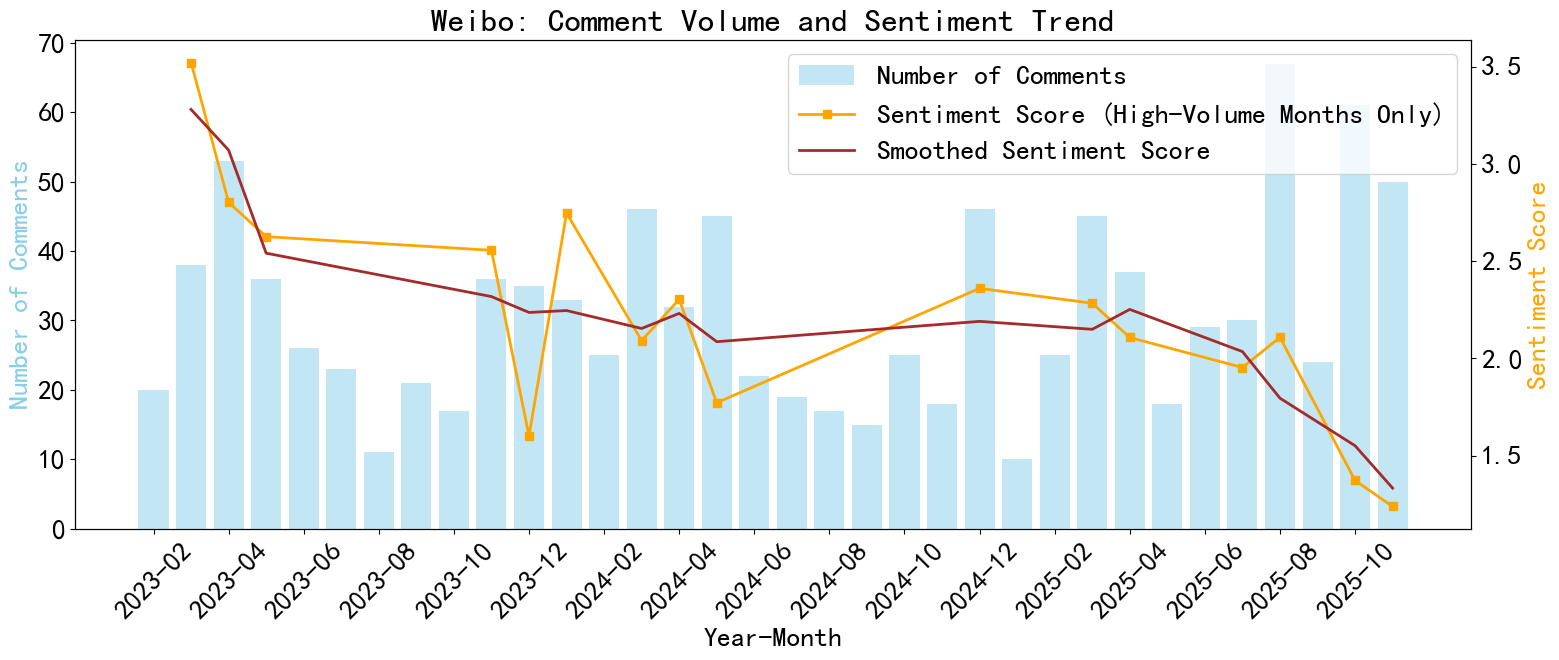

In [85]:
# Data preparation
min_count = 30
points = merged_filtered[merged_filtered['count'] >= min_count].copy()
plt.rcParams.update({'font.size': 20})
x_full = merged_filtered['year_month']
y_bar = merged_filtered['count']

x_line = points['year_month'].tolist()
y_line = pd.to_numeric(points['result'], errors='coerce').fillna(np.nan).values

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig, ax1 = plt.subplots(figsize=(16,7))

# Bar chart: comment volume for all months
ax1.bar(x_full, y_bar, color='skyblue', alpha=0.5, label='Number of Comments')
ax1.set_ylabel('Number of Comments', color='skyblue')
ax1.set_xlabel('Year-Month')

# Line chart: weighted sentiment score for high-volume months only
ax2 = ax1.twinx()
ax2.plot(x_line, y_line, 's-', color='orange', linewidth=2, label='Sentiment Score (High-Volume Months Only)')

# Plot smoothed sentiment curve using Savitzky-Golay filter
if len(y_line) >= 5:
    # window_length must be odd and ≤ number of data points
    win_len = min(7, len(y_line)) if len(y_line) % 2 == 1 else min(7, len(y_line)-1)
    win_len = max(3, win_len)
    y_smooth = savgol_filter(y_line, window_length=win_len, polyorder=2, mode='nearest')
    ax2.plot(x_line, y_smooth, '-', color='brown', linewidth=2, label='Smoothed Sentiment Score')
else:
    ax2.plot(x_line, y_line, '-', color='brown', linewidth=2, label='Smoothed Sentiment Score')

ax2.set_ylabel('Sentiment Score', color='orange')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, loc='upper right')

xticks_idx = range(0, len(x_full), 2)
ax1.set_xticks(xticks_idx)
ax1.set_xticklabels([x_full[i] for i in xticks_idx], rotation=45)
plt.title('Weibo: Comment Volume and Sentiment Trend')
plt.tight_layout()
plt.show()

In [86]:
# youtube

In [87]:
import pandas as pd
from transformers import pipeline,AutoTokenizer
from tqdm import tqdm

df = pd.read_csv("youtube_multi_videos_comments.csv")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

classifier = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer=tokenizer,
    truncation=True,
    max_length=512
)
def predict_sentiment_eng(text):
    result = classifier(text)[0]
    return pd.Series([result['label'], result['score']])

tqdm.pandas()
df[['pred_label_en', 'pred_score_en']] = df['text'].progress_apply(predict_sentiment_eng)

df.to_csv("youtube_labeled_with_pred_en.csv", index=False, encoding="utf-8-sig")

KeyboardInterrupt: 

In [88]:
df = pd.read_csv("youtube_labeled_with_pred_en.csv")

# Step 1: Convert string sentiment labels to numerical values
df['pred_label_num'] = df['pred_label_en'].map({'POSITIVE': 1, 'NEGATIVE': -1})

# Compute weight based on log-transformed like count for each comment
df['weight'] = np.log(df['like_count'] + 1)

# Step 2: Calculate weighted sentiment score
df['result'] = df['pred_label_num'] * df['pred_score_en'] * df['weight']

# Aggregate weighted sentiment scores by month
monthly_trend = df.groupby('year_month')['result'].mean().reset_index()

In [89]:
df = df[df['year_month'] >= '2023-02'].copy()
monthly_trend = df.groupby('year_month')['result'].mean().reset_index()
monthly_trend = monthly_trend.set_index('year_month').reindex(target_months).fillna(0).reset_index()
comment_counts = df.groupby('year_month').size().reset_index(name='count')
monthly_sentiment = df.groupby('year_month')['result'].mean().reset_index(name='result')
merged_filtered = pd.merge(comment_counts, monthly_sentiment, on='year_month', how='outer').sort_values('year_month')

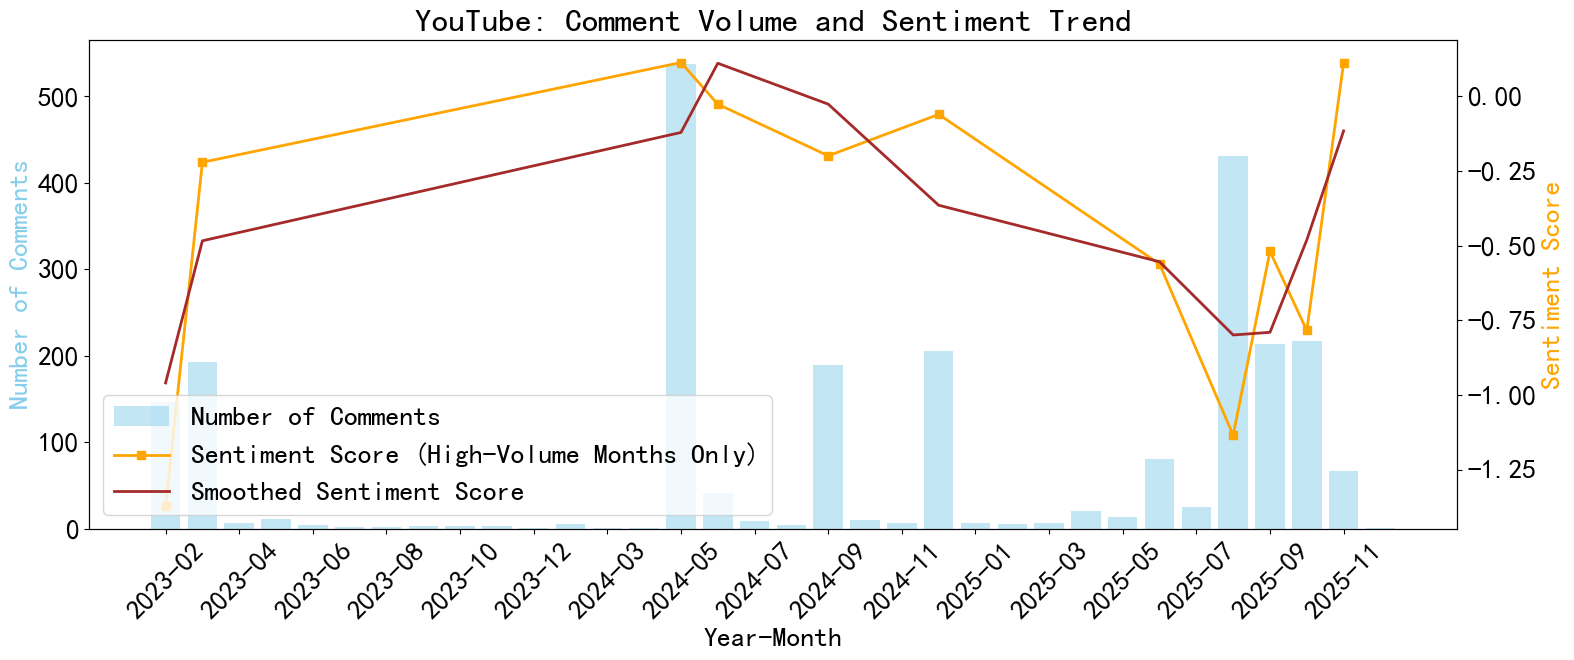

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

fig, ax1 = plt.subplots(figsize=(16,7))
plt.rcParams.update({'font.size': 20})
x_full = merged_filtered['year_month'].tolist()
y_bar = merged_filtered['count'].tolist()
points = merged_filtered[merged_filtered['count'] >= min_count]
x_line = points['year_month'].tolist()
y_line = points['result'].tolist()
ax1.bar(x_full, y_bar, color='skyblue', alpha=0.5, label='Number of Comments')
ax1.set_ylabel('Number of Comments', color='skyblue')
ax1.set_xlabel('Year-Month')

ax2 = ax1.twinx()
ax2.plot(x_line, y_line, 's-', color='orange', linewidth=2, label='Sentiment Score (High-Volume Months Only)')

if len(y_line) >= 5:
    win_len = min(7, len(y_line)) if len(y_line) % 2 == 1 else min(7, len(y_line)-1)
    win_len = max(3, win_len)
    y_smooth = savgol_filter(y_line, window_length=win_len, polyorder=2, mode='nearest')
    ax2.plot(x_line, y_smooth, '-', color='brown', linewidth=2, label='Smoothed Sentiment Score')
else:
    ax2.plot(x_line, y_line, '-', color='brown', linewidth=2, label='Smoothed Sentiment Score')

ax2.set_ylabel('Sentiment Score', color='orange')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, loc='lower left')

xticks_idx = range(0, len(x_full), 2)
ax1.set_xticks(xticks_idx)
ax1.set_xticklabels([x_full[i] for i in xticks_idx], rotation=45)

plt.title('YouTube: Comment Volume and Sentiment Trend')
plt.tight_layout()
plt.show()